In [44]:
# libraries to provide data process

import os
import cv2
import numpy as np

PREPARING DATA 

In [45]:
np.eye(2)

array([[1., 0.],
       [0., 1.]])

In [47]:
info = {"dir": 12, "classes": 33, "features": 65, "flag": 435, "baseSize": 'a'}
listo = [[3,4],[5, 1],[3,43],[5,4],[45,46],[546,4]]

arr  =np.asarray([info, listo])


listtt = np.asarray(listo)
print(listtt)
listtt = np.random.shuffle(listtt)
listtt

[[  3   4]
 [  5   1]
 [  3  43]
 [  5   4]
 [ 45  46]
 [546   4]]


In [48]:
listtt = np.asarray(listo)
print(listtt)
np.random.shuffle(listtt)

listtt

[[  3   4]
 [  5   1]
 [  3  43]
 [  5   4]
 [ 45  46]
 [546   4]]


array([[  5,   1],
       [546,   4],
       [  3,  43],
       [  5,   4],
       [  3,   4],
       [ 45,  46]])

In [49]:
#help(np.random.shuffle)

In [50]:
from tqdm import tqdm
from torch import Tensor

In [64]:
class data:
    """Class containing methods to process and call data
    
    Args:
    dir -- directory to main data folder
    classes -- name of the classes
    features -- ground truths of the data
    flag = type of the set
    baseSize = images' size to fix
    """
    #dir = '.data//pollut//train'
    #classes = ['class1', 'class2']
    #features = ['adapt_Dot//']
    #flag = 'train'
    #baseSize = 64
    
    #in order to change later, we can put init method.
    def __init__(self, dir = '.data\\pollut\\', classes = ['class1', 'class2'], features = ['adapt_Dot'], 
                 flag = 'train', baseSize = 64, data_title = 'data.npy'):
        self.dir = os.path.join(dir, flag)
        self.classes =classes
        self.features= features
        self.flag = flag
        self.baseSize = baseSize
        
        print("opening directory --> ", self.dir)
        self.image_dir = os.path.join(self.dir, 'images')
        self.features_dict = {}
        for i in range(len(features)): 
            #print(i)
            self.features_dict[f'{features[i]}']= (os.path.join(self.dir, features[i]))

        self.data_info = {"dir": self.dir, "classes": classes, "features": features, "flag": flag, 
                          "baseSize": baseSize, "data_title": data_title}
        print("information:\n", self.data_info, "\n")
        self.data_list = []
        self.data_dir = os.path.join(self.dir, data_title)
        #self.data = None
        self.data_dict = None

        self.number_ofImages = (len(os.listdir(self.image_dir)))
        self.im_count = 0

        self.class_number  = len(classes)
        self.eye_vector = np.eye(self.class_number)
        print("label vectors guide:")
        for j in range(len(classes)):
            print( f"{classes[j]}", self.eye_vector[j], "\n")
    
    def add_data(self, imageSize = None, save=True,  reset_Data= True):
        """
            imageSize : to change image size. careful not to change from already minimalized photo.
            save: to save data to (if not moved from root) replace previous one. 
            reset_Data: to reset written data list, to add new sample set False 
        
        """
        
        if reset_Data:
            print("resetting data --> ")
            self.data_list = []
            self.im_count = 0

        if imageSize == None:
            imageSize = self.baseSize
        
        print("image number:", self.im_count)
        if len(os.listdir(self.image_dir))>= len(self.classes):
            for i in (os.listdir(self.image_dir)):
                class_count = 0
                class_dir = os.path.join(self.image_dir, i)
                t = tqdm(os.listdir(class_dir))
                try:
                    for file in t:
                        t.set_description(f"processing folder --> {i}")
                        file_list = []
                        #print(os.path.join(class_dir, file))
                        _, no = file.split("image")
                        image = cv2.imread(os.path.join(class_dir, file), cv2.IMREAD_GRAYSCALE)
                        #print(image.shape)
                        image = cv2.resize(image, (imageSize, imageSize),  interpolation=cv2.INTER_CUBIC)
                        file_list.append(image)
                        if self.im_count ==0:
                            print("paused, image size is ", image.shape, ". continuing...")
                        for feature_title in self.features:
                            #print(self.features_dict)
                            feature_dir = self.features_dict[feature_title]
                            #print(os.path.join(feature_dir, i,f"dot{no}.jpg"))
                            feature = cv2.imread(os.path.join(feature_dir, i,f"dot{no}"), cv2.IMREAD_GRAYSCALE)
                            #print(feature)
                            feature = cv2.resize(feature, (imageSize, imageSize), interpolation=cv2.INTER_CUBIC)
                            file_list.append(feature)
                        target = self.classes.index(i) #find index of i 
                        one_hot_vector = self.eye_vector[target] 
                        #print(one_hot_vector, i )
                        file_list.append(one_hot_vector)
                        self.data_list.append(np.asarray(file_list))
                        class_count +=1
                        self.im_count += 1
                except Exception as e:
                    print("ERROR, maybe the data is corrupted or directory cannot be found or some files are missing..."
                          "Here is the actual error:")
                    print(e)
 
                print("processing done, number of added images \n in category", i, ":", class_count, "\n total:", self.im_count)
        else:
            print("ERROR, excessed with given class number!")
        
        #self.data = np.asarray(self.data_list)
        self.data_dict = np.asarray([{'info': self.data_info,'data':  np.asarray(self.data_list)}])
        #print(data.shape)
        if save:
            self.save_data(self.data_dict)
        return self.data_dict
        
    def load_data(self, directory = None):
        # load data from the folder
        if directory == None:
            print("loading from -->", self.data_dir)
            self.data_dict =np.load(self.data_dir, allow_pickle=True)
        else:
            print("loading from -->", sdirectory)
            self.data_dict = np.load(os.path.join(directory, 'data.npy'), allow_pickle=True)
        return self.data_dict 

    def save_data(self, data):
        print("saving to -->", self.data_dir)
        return np.save(self.data_dir, data)
    
    def to_torch_tensor(self, shuffle=True):
        """split numpy array to torch tensors in 8-bit"""
        if self.data_dict != None:
            rdata = self.data_dict[0]['data']
        else:
            try: 
                self.data_dict = self.load_data()
                rdata = self.data_dict[0]['data']
            except Exception as e:
                print(e)
                try: 
                    self.add_data()
                    self.data_dict = self.load_data()
                    rdata = self.data_dict[0]['data']
                except Exception as f:
                            print(f)
                            print("Error, data is not found!")
        if shuffle:
            np.random.shuffle(rdata)
        if rdata != None:
            x= Tensor([i[0] for i in rdata]) / 255.0
            #print(x.dtype, x.shape)
            y = []
            for f in range((rdata.shape[1]-2)):
                #print(f)
                y.append(Tensor([i[f+1] for i in rdata]) / 255.0) #features
            #y = Tensor(y)
            #print(y[0].shape)
            c = Tensor([i[-1] for i in rdata]) #class info
            #print(c.dtype, c.shape)
            
            #transposing as (number_of_samples, channels, height, width)
            x = x.reshape(-1, 1, self.baseSize, self.baseSize)
            for j in range (len(y)):
                y[j] = y[j].reshape(-1, 1, self.baseSize, self.baseSize) #y[j] = y[j].permute(0, -1, 1, 2)
            #print(len(y))
            return x, y, c
        else: return

In [65]:
pollut = data()

opening directory -->  .data\pollut\train
information:
 {'dir': '.data\\pollut\\train', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'train', 'baseSize': 64, 'data_title': 'data.npy'} 

label vectors guide:
class1 [1. 0.] 

class2 [0. 1.] 



In [66]:
pollut.add_data()

processing folder --> class1:   4%|▍         | 1/26 [00:00<00:04,  5.56it/s]

resetting data --> 
image number: 0
paused, image size is  (64, 64) . continuing...


processing folder --> class2:   0%|          | 0/40 [00:00<?, ?it/s]

processing done, number of added images 
 in category class1 : 26 
 total: 26


processing folder --> class2: 100%|██████████| 40/40 [00:03<00:00, 10.10it/s]

processing done, number of added images 
 in category class2 : 40 
 total: 66
saving to --> .data\pollut\train\data.npy


array([{'info': {'dir': '.data\\pollut\\train', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'train', 'baseSize': 64, 'data_title': 'data.npy'}, 'data': array([[array([[13, 20, 19, ...,  3,  4,  2],
       [16, 27, 33, ...,  4,  4,  2],
       [26, 29, 29, ...,  3,  6,  1],
       ...,
       [25, 23, 25, ...,  5,  6,  5],
       [21, 23, 23, ...,  7,  6,  2],
       [16, 22, 18, ...,  5,  6,  8]], dtype=uint8),
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
        array([1., 0.])],
       [array([[ 57,  62,  45, ..., 102, 102,  99],
       [ 60,  63,  51, ...,  99,  96, 103],
       [ 54,  54,  52, ...,  94, 100, 106],
       ...,
       [ 30,  32,  30, ..., 223, 230, 233],
       [ 27,  31,  32, ..., 224, 229, 233],
       [ 26,  32,  33, ..., 225, 229, 235]], dtype=uint8),
        a

In [ ]:
# to change size or reset data

pollut.add_data(imageSize = 128, save=False, reset_Data=True)

In [ ]:
#to change parameters after declaring class--

pollut.__init__(dir = '.data\\pollut\\', classes = ['class1', 'class2'], features = ['adapt_Dot'], 
                 flag = 'train', baseSize = 64)

pollut.add_data(imageSize = 128, save=False, reset_Data=True)

# or.. just declare a new object

new_object = data(dir = '.data\\pollut\\', classes = ['class1', 'class2'], features = ['adapt_Dot'], 
                 flag = 'train', baseSize = 64)

In [67]:
my_data = pollut.load_data()
my_data[0]['info']

loading from --> .data\pollut\train\data.npy


{'dir': '.data\\pollut\\train',
 'classes': ['class1', 'class2'],
 'features': ['adapt_Dot'],
 'flag': 'train',
 'baseSize': 64,
 'data_title': 'data.npy'}

In [68]:
import matplotlib.pyplot as plt

def visualize(my_data, indices=None):
    #.......
    dicto = my_data[0]
    data = dicto['data']
    print(dicto['info'])
    plt.figure()
    nrows = indices[1]-indices[0]+1
    ncols = data.shape[1]-1
    #print(nrows, ncols)
    ct = 1
    case1 = (indices[0]<= indices[1])
    case2 = (indices[1] <= len(data))
    case3 = ( indices[0] <= len(data))
    case4 = indices[0] >=0 and indices[1] >= 0 
    if  case1 and case2 and case3 and case4:
        print("classes respectively:")
        for i in range(nrows):
            for j in range(ncols):
                plt.subplot(nrows, ncols , ct)
                ct +=1
                #print(i, j, i+j+1)
                plt.imshow(data[i+indices[0]][j])
            print(data[i+indices[0]][-1])
    else:
        print("invalid indices!" , case1, case2, case3, case4)
    return

{'dir': '.data\\pollut\\train', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'train', 'baseSize': 64, 'data_title': 'data.npy'}
classes respectively:
[1. 0.]


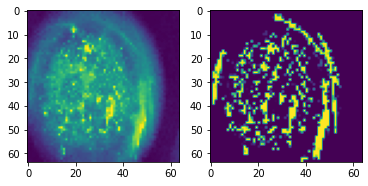

In [69]:
visualize(my_data, indices=(6,6))

In [70]:
print(pollut.data_dict[0]['info'])

x, y, c = pollut.to_torch_tensor()

{'dir': '.data\\pollut\\train', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'train', 'baseSize': 64, 'data_title': 'data.npy'}


C:\Users\baran.tanriverdi\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:148: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


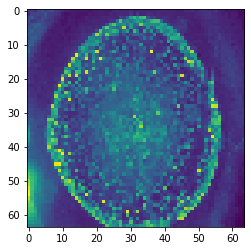

In [71]:
plt.imshow(x[1].permute(1,2,0))

In [16]:
class Augmentation():
    #....
    def __init__(args= None):
         #...
        print("Augmented!!")
    def normalize():
        return
    def randomCrop():
        return
    def randomFlip():
        return
    
    def ComposeTransformations():
        return

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 

#class DataLoader():
    #...
print("WILL DO!")

WILL DO!


MODEL & METRICS

In [72]:
import segmentation_models_pytorch as smp


ENCODER = 'resnet34'
ENCODER_WEIGHTS = None
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cpu'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels = 1,
    classes=1, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
    aux_params= {'classes': 2, 'pooling': 'avg', 'dropout': 0.3 , 'activation': 'softmax' }
)

inin = x[1].unsqueeze(0)
print(inin.shape)
outout = model(inin)
outout


torch.Size([1, 1, 64, 64])


(tensor([[[[0.5754, 0.6016, 0.5370,  ..., 0.5527, 0.6325, 0.4753],
           [0.5031, 0.2571, 0.1109,  ..., 0.4624, 0.6089, 0.4091],
           [0.5933, 0.4802, 0.5211,  ..., 0.7723, 0.6836, 0.4475],
           ...,
           [0.5114, 0.6608, 0.2639,  ..., 0.5734, 0.7046, 0.4438],
           [0.4892, 0.3509, 0.2235,  ..., 0.7328, 0.7117, 0.4068],
           [0.4214, 0.6323, 0.5395,  ..., 0.3534, 0.3609, 0.3308]]]],
        grad_fn=<SigmoidBackward>),
 tensor([[0.3175, 0.6825]], grad_fn=<SoftmaxBackward>))

torch.Size([1, 1, 64, 64])


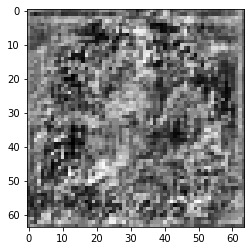

In [73]:
plt.imshow(outout[0].detach().numpy().squeeze(0).transpose(1,2,0), cmap='gray')
print(outout[0].shape)


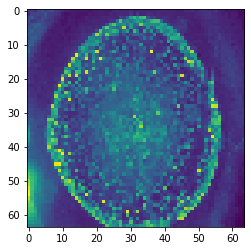

In [74]:
plt.imshow(x[1].permute(1,2,0))

In [75]:
import torch
loss_function= smp.utils.losses.DiceLoss()

loss_fn_for_classf  = smp.utils.losses.MSELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [76]:
def fwd_pass(X, y, c, net, train_=False):
    if train_:
        net.zero_grad()
    outputs = net(X)
    yhat = outputs[0]
    iou = metrics[0](yhat, y)
    loss_1 = loss_function(yhat, y)
    
    probs = outputs[1]
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(probs, c)]
    acc = matches.count(True) / len(matches)
    loss_2 = loss_fn_for_classf(probs,c )
    
    loss = loss_1 + loss_2
# https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348/7
    if train_:
        loss.backward()
        optimizer.step()

    return iou, loss_1, acc, loss_2

In [77]:
train_Ds = TensorDataset(x[:50], y[0][:50], c[:50])
train_ld = DataLoader(train_Ds , batch_size = 4, shuffle=True)

valid_Ds = TensorDataset(x[50:], y[0][50:], c[50:])
print(len(valid_Ds))
valid_ld = DataLoader(valid_Ds, batch_size = 1)


16


In [78]:
EPOCHS = 40
BATCH_SIZE = 4
MODEL_NAME = '64gry_resnet34_sigmoid_cpu_depthdf_40ep_4bs_lre-4to-5_th05_bntr_class1n2'
LOG = f".models/{MODEL_NAME}.log"


def train(epochs= EPOCHS, model = model, batch_size = BATCH_SIZE, log = LOG):
    cf_scores = []
    with open(LOG, "w") as f:
        f.write("Epoch | training loss | training iou score | validation loss | validation iou score ")
        for i in tqdm(range(0, EPOCHS)):
            #print(f"Epoch: {i}")
            for j in range(0, int(len(valid_ld))):   
                dt = next(iter(train_ld))
                batch_X = dt[0]
                batch_y = dt[1]
                batch_c = dt[2]

                iou, loss_1, acc, loss_2  = fwd_pass(batch_X, batch_y ,  batch_c,  model, train_=True)
                
                val = next(iter(valid_ld))
                val_x = dt[0]
                val_y = dt[1]
                val_c = dt[2]

                val_iou, val_loss_1, val_acc, val_loss_2  = fwd_pass(val_x, val_y ,val_c, model, train_=False)
            #tqdm.write(f"{acc, loss, val_acc, val_loss}")
            f.write(f"\n {i};" 
                     f"{iou};{loss_1}; {acc}; {loss_2};" 
                     f"{val_iou}; {val_loss_1}; {val_acc}; {val_loss_2}")
    torch.save(model, '64gry_resnet34_sigmoid_cpu_depthdf_40ep_4bs_lre-4to-5_th05_bntr_class1n2.pth')
        

In [79]:
train()

100%|██████████| 40/40 [07:14<00:00, 10.86s/it]


In [29]:
int(len(valid_ld)) 

16

not enough values to unpack (expected 9, got 1)
skipping first row
0.6177902221679688
0.312968373298645
1.0
1.1046413783688536e-11
0.6213595271110535
0.3110201954841614
1.0
3.36574165890266e-13
40 40
<class 'list'> <class 'list'>


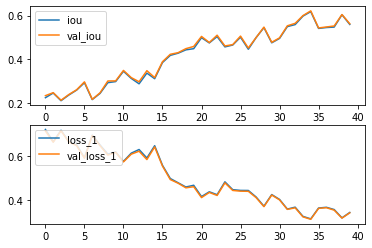

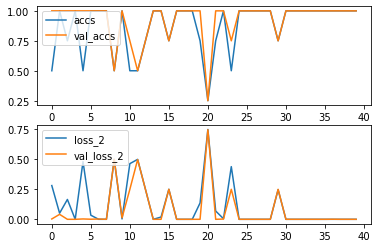

In [149]:
SAVE_DIR = f'.models/{MODEL_NAME}.png'

def create_acc_loss_graph(log= LOG, save_dir= SAVE_DIR):
    contents = open(log, "r").read().split("\n")

    epochs = []
    
    ious = []
    loss_1s = []
    accs = []
    loss_2s = []
    
    val_ious = []
    val_loss_1s = []
    val_accs =[]
    val_loss_2s =[]
    
    for c in contents:
        try:
            epoch, iou, loss_1, acc, loss_2 , val_iou, val_loss_1, val_acc, val_loss_2 = c.split(";")

            epochs.append(int(epoch))
            
            ious.append(float(iou))
            loss_1s.append(float(loss_1))
            accs.append(float(acc))
            loss_2s.append(float(loss_2))

            val_ious.append(float(val_iou))
            val_loss_1s.append(float(val_loss_1))
            val_accs.append(float(val_acc))
            val_loss_2s.append(float(val_loss_2))
            
        except Exception as e:
            print(e)
            print("skipping first row")
    
    print(np.max(np.array(ious)))
    print(np.min(np.array(loss_1s)))
    print(np.max(np.array(accs)))
    print(np.min(np.array(loss_2s)))
    
    print(np.max(np.array(val_ious)))
    print(np.min(np.array(val_loss_1s)))
    print(np.max(np.array(val_accs)))
    print(np.min(np.array(val_loss_2s)))
    
    
    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)


    
    print(len(ious), len(val_ious))
    print(type(ious), type(accs))
    ax1.plot(epochs, ious, label="iou")
    ax1.plot(epochs, val_ious, label="val_iou")
    ax1.legend(loc=2)
    
    ax2.plot(epochs, loss_1s, label="loss_1")
    ax2.plot(epochs, val_loss_1s, label="val_loss_1")
    ax2.legend(loc=2)
    plt.show()

    fig = plt.figure()
    ax3 = plt.subplot2grid((2, 1), (0, 0))
    ax4 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)
    
    ax3.plot(epochs, accs, label="accs")
    ax3.plot(epochs, val_accs, label="val_accs")
    ax3.legend(loc=2)
    
    ax4.plot(epochs, loss_2s, label="loss_2")
    ax4.plot(epochs, val_loss_2s, label="val_loss_2")
    ax4.legend(loc=2)

    plt.savefig(save_dir)
    plt.show()
    
    

create_acc_loss_graph()

torch.Size([1, 1, 64, 64])
tensor([[7.2866e-05, 9.9993e-01]], grad_fn=<SoftmaxBackward>)


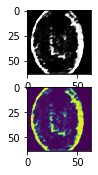

In [94]:
model = torch.load('64gry_resnet34_sigmoid_cpu_depthdf_40ep_4bs_lre-4to-5_th05_bntr_class1n2.pth')

inin = x[24].unsqueeze(0)
print(inin.shape)
outout = model(inin)
plt.subplot(3,1,1)
out = outout[0].detach().numpy().squeeze(0).transpose(1,2,0)
plt.imshow(out, cmap='gray')
plt.subplot(3,1,2)
plt.imshow(y[0][24].permute(1,2,0))
print(outout[1])
#plt.subplot(3,1,3)
plt.imshow(x[24].permute(1,2,0) + out*30)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])


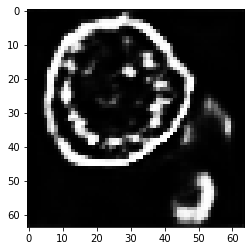

In [82]:
inin = x[19].unsqueeze(0)
print(inin.shape)
outout = model(inin)
plt.imshow(outout[0].detach().numpy().squeeze(0).transpose(1,2,0), cmap='gray')
print(outout[0].shape)

In [ ]:
#help(smp.Unet)

In [111]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [96]:
test_dt = data(flag= 'test')

opening directory -->  .data\pollut\test
information:
 {'dir': '.data\\pollut\\test', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'test', 'baseSize': 64, 'data_title': 'data.npy'} 

label vectors guide:
class1 [1. 0.] 

class2 [0. 1.] 



In [98]:
test_dt.add_data()

processing folder --> class1:  20%|██        | 1/5 [00:00<00:00,  7.69it/s]

resetting data --> 
image number: 0
paused, image size is  (64, 64) . continuing...


processing folder --> class2:   9%|▉         | 1/11 [00:00<00:01,  7.09it/s]

processing done, number of added images 
 in category class1 : 5 
 total: 5


processing folder --> class2: 100%|██████████| 11/11 [00:01<00:00,  9.53it/s]

processing done, number of added images 
 in category class2 : 11 
 total: 16
saving to --> .data\pollut\test\data.npy


array([{'info': {'dir': '.data\\pollut\\test', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'test', 'baseSize': 64, 'data_title': 'data.npy'}, 'data': array([[array([[ 53,  55,  56, ...,  30,  27,  33],
       [ 58,  56,  53, ...,  32,  32,  39],
       [ 57,  54,  55, ...,  34,  32,  36],
       ...,
       [ 25,  34,  25, ...,  63,  87, 118],
       [ 34,  31,  25, ...,  54,  82, 107],
       [ 33,  27,  20, ...,  59,  88,  97]], dtype=uint8),
        array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
        array([1., 0.])],
       [array([[31, 27, 28, ..., 12, 18, 13],
       [27, 32, 30, ..., 18, 13, 15],
       [31, 20, 28, ..., 19, 17, 17],
       ...,
       [31, 33, 34, ..., 17, 17, 14],
       [30, 28, 21, ..., 13,  9, 11],
       [16, 18, 18, ..., 10, 10,  7]], dtype=uint8),
        arr

In [99]:
xt, yt, ct = test_dt.to_torch_tensor()

C:\Users\baran.tanriverdi\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:148: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


loading from --> .data\pollut\test\data.npy
{'dir': '.data\\pollut\\test', 'classes': ['class1', 'class2'], 'features': ['adapt_Dot'], 'flag': 'test', 'baseSize': 64, 'data_title': 'data.npy'}
classes respectively:
[1. 0.]
[1. 0.]
[1. 0.]


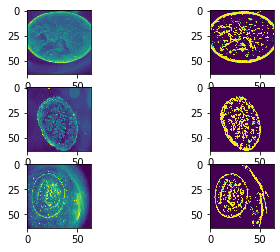

In [102]:
visualize(test_dt.load_data(), indices=(1,3))

In [104]:
print(fwd_pass(xt, yt, ct, model, train_=False))

TypeError: only integer tensors of a single element can be converted to an index

In [106]:
test_Ds = TensorDataset(xt, yt[0], ct)
print(len(test_Ds))
test_ld = DataLoader(test_Ds, batch_size = 1)

16


In [146]:
iou, loss_1, acc, loss_2  = 0,0,0,0
for j in range(0, int(len(valid_ld))):   
    dt = next(iter(train_ld))
    batch_X = dt[0]
    batch_y = dt[1]
    batch_c = dt[2]

    iou, loss_1, acc, loss_2 = np.array([iou, loss_1, acc, loss_2])  + np.array(fwd_pass(batch_X, batch_y, batch_c, model, train_=False))  
    
avg1, avg2, avg3, avg4 = iou/j, loss_1/j, acc/j, loss_2/j

In [147]:
print(avg1, avg2,avg3,avg4)

tensor(0.6274) tensor(0.3528, grad_fn=<DivBackward0>) 1.0666666666666667 tensor(6.8513e-06, grad_fn=<DivBackward0>)
